# Preprocessing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.applications.resnet import ResNet50, preprocess_input

In [ ]:
dataset = tfds.builder('eurosat')
info = dataset.info
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir='/root/tensorflow_datasets/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised

In [ ]:
info.features

FeaturesDict({
    'filename': Text(shape=(), dtype=string),
    'image': Image(shape=(64, 64, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})

In [ ]:
class_names = []
for i in range(info.features["label"].num_classes):
  class_names.append(info.features["label"].int2str(i))

class_names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [ ]:
list(info.splits.keys())

['train']

In [ ]:
(train, val, test) = tfds.load("eurosat/rgb", split=["train[:50%]", "train[50%:90%]", "train[90%:]"])

In [ ]:
type(train)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [ ]:
datapoint = next(iter(train))
datapoint

{'filename': <tf.Tensor: shape=(), dtype=string, numpy=b'Forest_687.jpg'>,
 'image': <tf.Tensor: shape=(64, 64, 3), dtype=uint8, numpy=
 array([[[35, 59, 71],
         [35, 59, 71],
         [36, 60, 72],
         ...,
         [32, 60, 72],
         [31, 59, 70],
         [33, 63, 73]],
 
        [[35, 59, 71],
         [34, 61, 72],
         [37, 61, 73],
         ...,
         [31, 59, 70],
         [31, 59, 70],
         [33, 63, 73]],
 
        [[37, 64, 73],
         [35, 64, 72],
         [38, 65, 74],
         ...,
         [35, 63, 74],
         [31, 59, 70],
         [32, 61, 69]],
 
        ...,
 
        [[31, 54, 70],
         [29, 55, 68],
         [32, 59, 70],
         ...,
         [33, 62, 70],
         [32, 60, 71],
         [34, 62, 73]],
 
        [[33, 59, 72],
         [32, 59, 70],
         [32, 59, 70],
         ...,
         [32, 60, 71],
         [37, 66, 74],
         [35, 65, 73]],
 
        [[34, 62, 73],
         [33, 61, 72],
         [35, 62, 73],
     

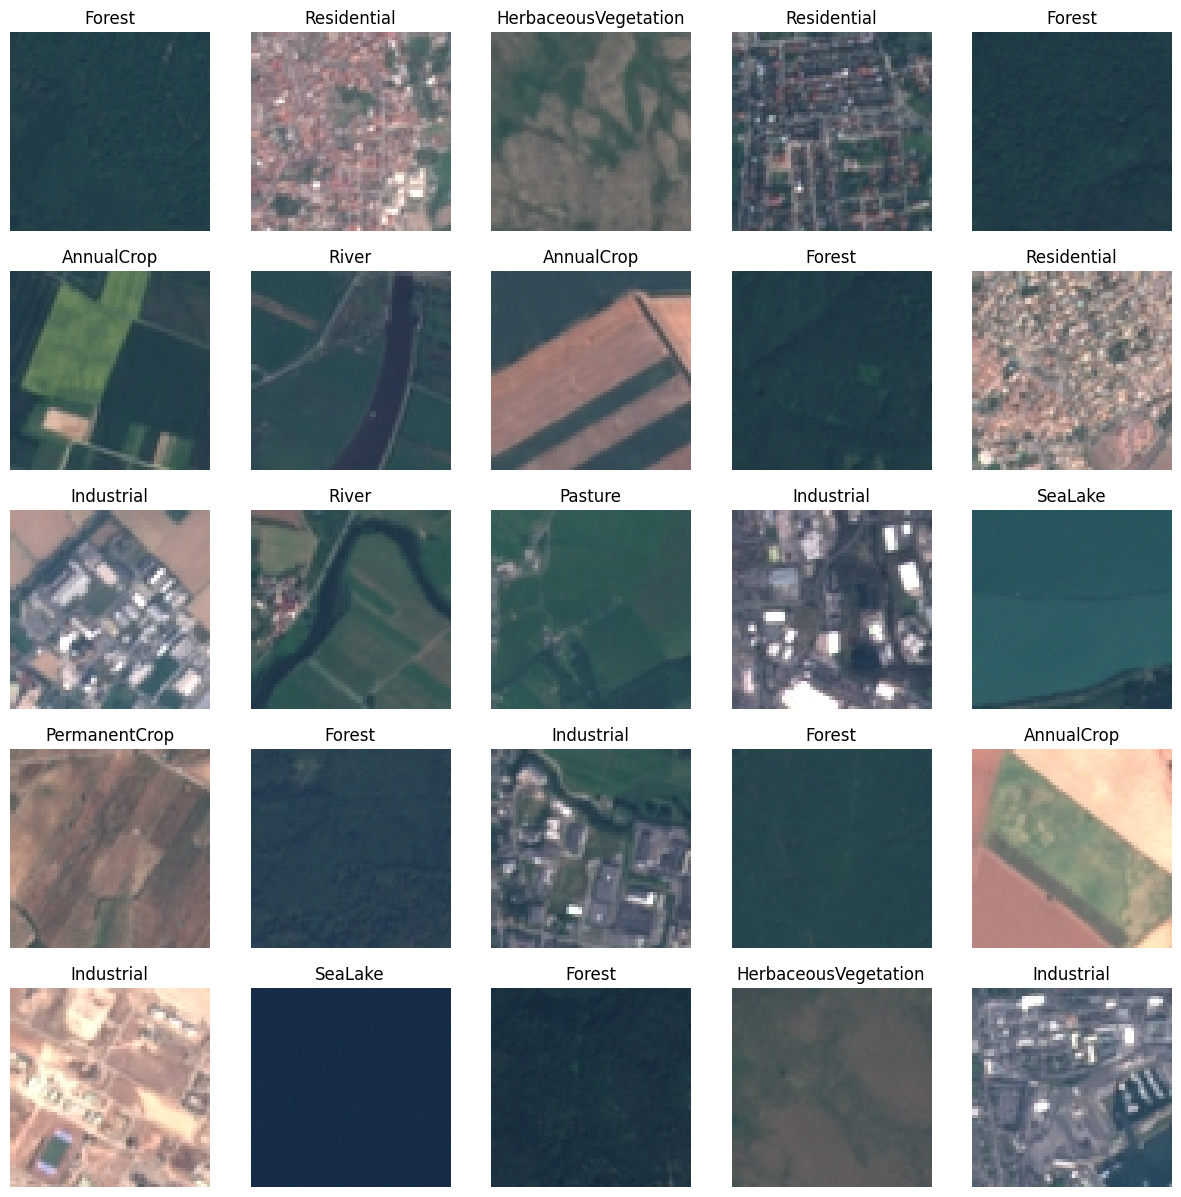

In [ ]:
plt.figure(figsize=(15, 15))
for i, datapoint in enumerate(tfds.as_numpy(train.take(25))):
  ax = plt.subplot(5, 5, i+1)
  plt.imshow(datapoint["image"])
  plt.title(class_names[datapoint["label"]])
  plt.axis("off")
plt.show()

# Resnet50

In [ ]:
NUM_EPOCHS = 5
BATCH_SIZE = 128
BUFFER_SIZE = 1000

IMAGE_SHAPE = [180, 180]
NUM_CLASSES = info.features["label"].num_classes

In [ ]:
tf.random.uniform(())  # This will generate a radom floating number from 0-1

<tf.Tensor: shape=(), dtype=float32, numpy=0.38424587>

In [ ]:
@tf.function
def prepare_training_data(datapoint):
  input_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)

  input_image = preprocess_input(input_image)

  return input_image, datapoint["label"]

def prepare_validation_data(datapoint):
  input_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)
  input_image = preprocess_input(input_image)

  return input_image, datapoint["label"]

In [ ]:
train = train.map(prepare_training_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation = val.map(prepare_validation_data)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation.batch(BATCH_SIZE)

In [ ]:
resnet = ResNet50(input_shape=IMAGE_SHAPE+[3], weights='imagenet', include_top=False)

for layer in resnet.layers:
  layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(resnet.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(20, activation='relu')(x)
predicition = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.models.Model(inputs=resnet.input, outputs=predicition)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# STEPS_PER_EPOCH = int(info.splits["train"].num_examples * 0.5)//BATCH_SIZE
STEPS_PER_EPOCH = 10
VALIDATION_STEPS = int(info.splits["train"].num_examples * 0.1)//BATCH_SIZE

In [ ]:
history = model.fit(
    train_dataset,
    epochs = NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_dataset,
    validation_steps=VALIDATION_STEPS
)

Epoch 1/5
10/10 [==============================] - 29s 1s/step - loss: 2.0826 - accuracy: 0.2875 - val_loss: 1.5850 - val_accuracy: 0.4706
Epoch 2/5
10/10 [==============================] - 9s 1s/step - loss: 1.3241 - accuracy: 0.6039 - val_loss: 1.0162 - val_accuracy: 0.7214
Epoch 3/5
10/10 [==============================] - 14s 2s/step - loss: 0.8668 - accuracy: 0.7789 - val_loss: 0.6789 - val_accuracy: 0.8367
Epoch 4/5
10/10 [==============================] - 10s 1s/step - loss: 0.6244 - accuracy: 0.8430 - val_loss: 0.5025 - val_accuracy: 0.8683
Epoch 5/5
10/10 [==============================] - 13s 1s/step - loss: 0.4678 - accuracy: 0.8758 - val_loss: 0.3840 - val_accuracy: 0.9010


<Axes: >

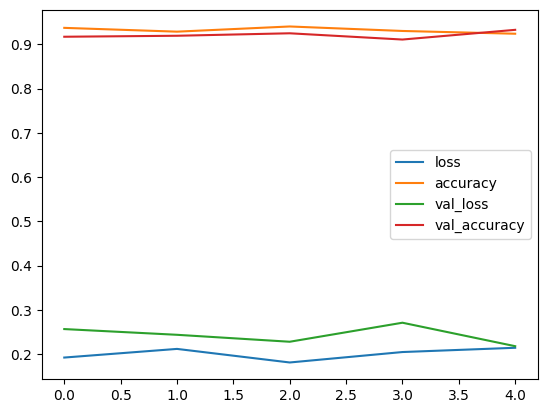

In [ ]:
import pandas as pd

pd.DataFrame(
    history.history
).plot()

In [ ]:
test_dataset = test.map(prepare_validation_data)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
model.evaluate(test_dataset)

22/22 [==============================] - 371s 17s/step - loss: 0.1936 - accuracy: 0.9333


[0.19362549483776093, 0.9333333373069763]

1/1 [==============================] - 0s 152ms/step


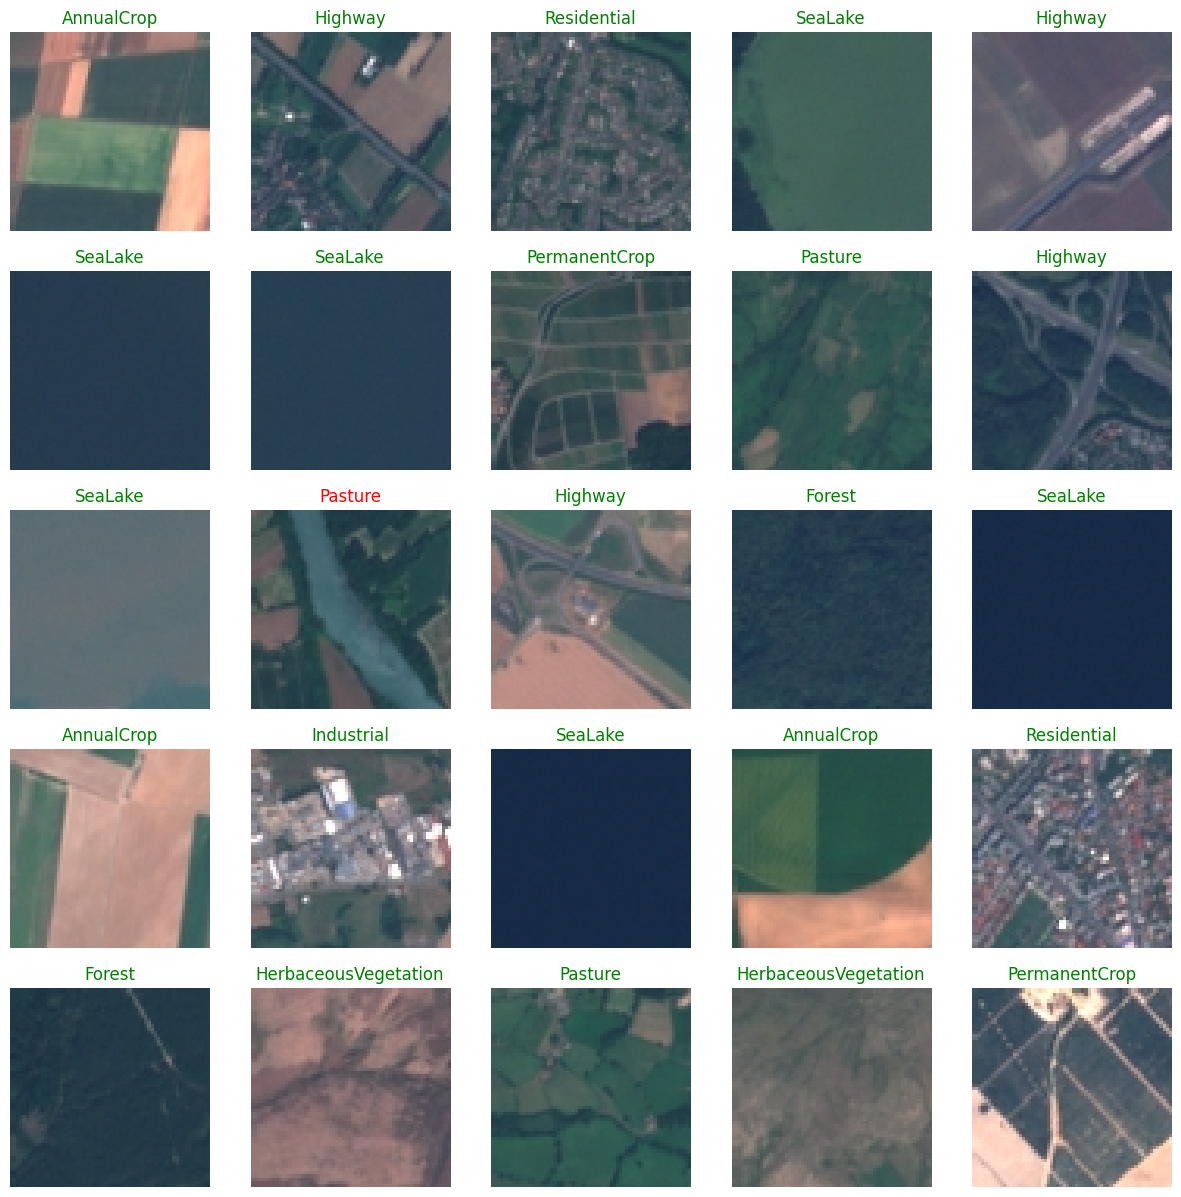

In [ ]:
plt.figure(figsize=(15, 15))
for i, datapoint in enumerate(tfds.as_numpy(test.take(25))):
  ax = plt.subplot(5, 5, i+1)
  plt.imshow(datapoint["image"])
  image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)
  image = preprocess_input(image)
  image = np.expand_dims(image, axis=0)

  if datapoint["label"] == np.argmax(model.predict(image)):
    plt.title(class_names[np.argmax(model.predict(image))], color="green")
  else:
    plt.title(class_names[np.argmax(model.predict(image))], color="red")

  plt.axis("off")

plt.show()

# VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [ ]:
NUM_EPOCHS = 5
BATCH_SIZE = 128
BUFFER_SIZE = 1000

IMAGE_SHAPE = [224, 224]
NUM_CLASSES = info.features["label"].num_classes

In [ ]:
tf.random.uniform(())  # This will generate a radom floating number from 0-1

<tf.Tensor: shape=(), dtype=float32, numpy=0.21081817>

In [ ]:
@tf.function
def prepare_training_data(datapoint):
  input_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.random_flip_left_right(input_image)
    input_image = tf.image.random_flip_up_down(input_image)
    input_image = tf.image.random_brightness(input_image, max_delta=0.3)
    input_image = tf.image.random_saturation(input_image, lower=0.75, upper=1.5)
    input_image = tf.image.random_contrast(input_image, lower=0.75, upper=1.5)

  input_image = preprocess_input(input_image)

  return input_image, datapoint["label"]

def prepare_validation_data(datapoint):
  input_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)
  input_image = preprocess_input(input_image)

  return input_image, datapoint["label"]

In [ ]:
train = train.map(prepare_training_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation = val.map(prepare_validation_data)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation.batch(BATCH_SIZE)

In [ ]:
vgg16 = VGG16(input_shape=IMAGE_SHAPE+[3], weights='imagenet', include_top=False)

for layer in vgg16.layers:
  layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(vgg16.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
predicition = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.models.Model(inputs=vgg16.input, outputs=predicition)

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
STEPS_PER_EPOCH = 8
VALIDATION_STEPS = int(info.splits["train"].num_examples * 0.1)//BATCH_SIZE

In [ ]:
history = model.fit(
    train_dataset,
    epochs = NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_dataset,
    validation_steps=VALIDATION_STEPS
)

Epoch 1/5
8/8 [==============================] - 37s 2s/step - loss: 1.4321 - accuracy: 0.5732 - val_loss: 0.6021 - val_accuracy: 0.8173
Epoch 2/5
8/8 [==============================] - 14s 2s/step - loss: 0.4873 - accuracy: 0.8340 - val_loss: 0.4032 - val_accuracy: 0.8765
Epoch 3/5
8/8 [==============================] - 14s 2s/step - loss: 0.3490 - accuracy: 0.8809 - val_loss: 0.3440 - val_accuracy: 0.8936
Epoch 4/5
8/8 [==============================] - 25s 3s/step - loss: 0.2803 - accuracy: 0.9141 - val_loss: 0.3012 - val_accuracy: 0.9048
Epoch 5/5
8/8 [==============================] - 26s 4s/step - loss: 0.3455 - accuracy: 0.9092 - val_loss: 0.3148 - val_accuracy: 0.8955


<Axes: >

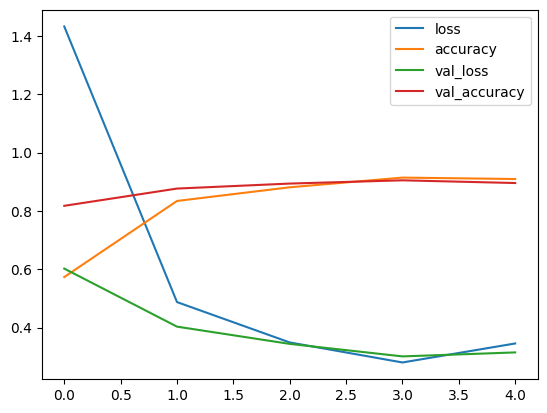

In [ ]:
import pandas as pd

pd.DataFrame(
    history.history
).plot()

In [ ]:
test_dataset = test.map(prepare_validation_data)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
model.evaluate(test_dataset)

22/22 [==============================] - 13s 557ms/step - loss: 0.2869 - accuracy: 0.9007


[0.28694626688957214, 0.9007407426834106]

1/1 [==============================] - 0s 18ms/step


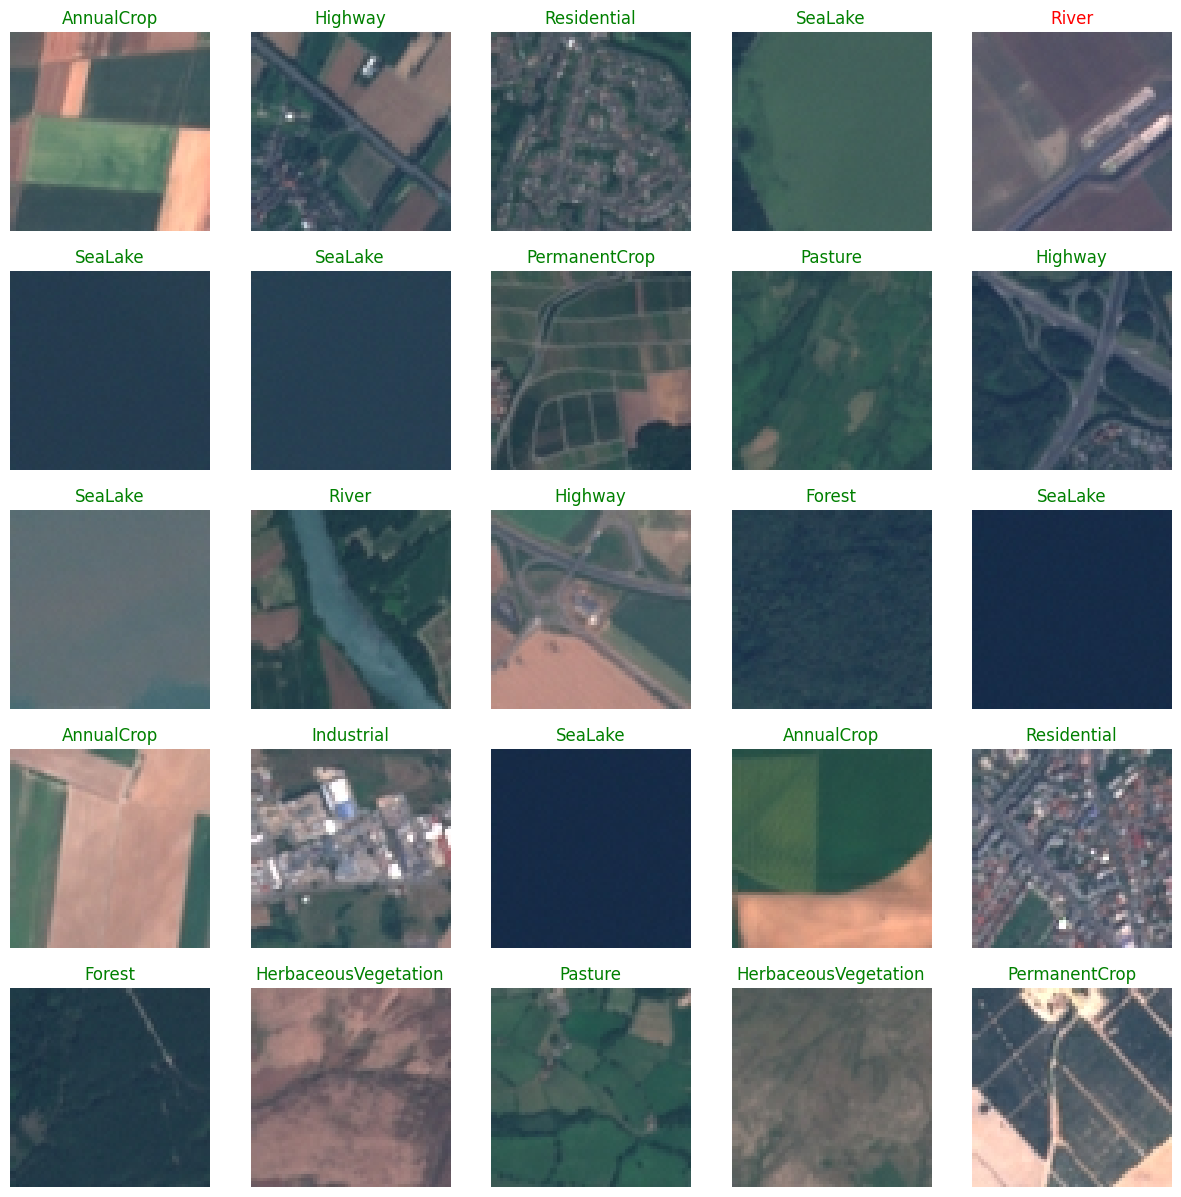

In [ ]:
plt.figure(figsize=(15, 15))
for i, datapoint in enumerate(tfds.as_numpy(test.take(25))):
  ax = plt.subplot(5, 5, i+1)
  plt.imshow(datapoint["image"])
  image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)
  image = preprocess_input(image)
  image = np.expand_dims(image, axis=0)

  if datapoint["label"] == np.argmax(model.predict(image)):
    plt.title(class_names[np.argmax(model.predict(image))], color="green")
  else:
    plt.title(class_names[np.argmax(model.predict(image))], color="red")

  plt.axis("off")

plt.show()

# DenseNet201

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input

In [ ]:
NUM_EPOCHS = 5
BATCH_SIZE = 128
BUFFER_SIZE = 1000

IMAGE_SHAPE = [224, 224]
NUM_CLASSES = info.features["label"].num_classes

In [ ]:
tf.random.uniform(())  # This will generate a radom floating number from 0-1

<tf.Tensor: shape=(), dtype=float32, numpy=0.6690469>

In [ ]:
@tf.function
def prepare_training_data(datapoint):
  input_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.random_flip_left_right(input_image)
    input_image = tf.image.random_flip_up_down(input_image)
    input_image = tf.image.random_brightness(input_image, max_delta=0.3)
    input_image = tf.image.random_saturation(input_image, lower=0.75, upper=1.5)
    input_image = tf.image.random_contrast(input_image, lower=0.75, upper=1.5)

  input_image = preprocess_input(input_image)

  return input_image, datapoint["label"]

def prepare_validation_data(datapoint):
  input_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)
  input_image = preprocess_input(input_image)

  return input_image, datapoint["label"]

In [ ]:
train = train.map(prepare_training_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation = val.map(prepare_validation_data)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation.batch(BATCH_SIZE)

In [ ]:
denseNet = DenseNet201(input_shape=IMAGE_SHAPE+[3], weights='imagenet', include_top=False)

for layer in denseNet.layers:
  layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(denseNet.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
predicition = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.models.Model(inputs=denseNet.input, outputs=predicition)

In [ ]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# STEPS_PER_EPOCH = int(info.splits["train"].num_examples * 0.5)//BATCH_SIZE
STEPS_PER_EPOCH = 8
VALIDATION_STEPS = int(info.splits["train"].num_examples * 0.1)//BATCH_SIZE

In [ ]:
history = model.fit(
    train_dataset,
    epochs = NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_dataset,
    validation_steps=VALIDATION_STEPS
)

Epoch 1/5
8/8 [==============================] - 58s 4s/step - loss: 1.3918 - accuracy: 0.5762 - val_loss: 0.6797 - val_accuracy: 0.7972
Epoch 2/5
8/8 [==============================] - 16s 2s/step - loss: 0.5366 - accuracy: 0.8350 - val_loss: 0.4157 - val_accuracy: 0.8661
Epoch 3/5
8/8 [==============================] - 16s 2s/step - loss: 0.3794 - accuracy: 0.8701 - val_loss: 0.3228 - val_accuracy: 0.9003
Epoch 4/5
8/8 [==============================] - 25s 3s/step - loss: 0.3129 - accuracy: 0.8926 - val_loss: 0.3143 - val_accuracy: 0.8951
Epoch 5/5
8/8 [==============================] - 16s 2s/step - loss: 0.2679 - accuracy: 0.9141 - val_loss: 0.3072 - val_accuracy: 0.8984


<Axes: >

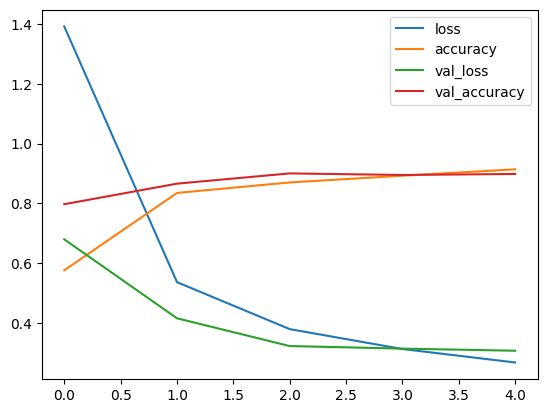

In [ ]:
import pandas as pd

pd.DataFrame(
    history.history
).plot()

In [ ]:
test_dataset = test.map(prepare_validation_data)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
model.evaluate(test_dataset)

22/22 [==============================] - 14s 643ms/step - loss: 0.2619 - accuracy: 0.9130


[0.2619035840034485, 0.9129629731178284]

1/1 [==============================] - 0s 60ms/step


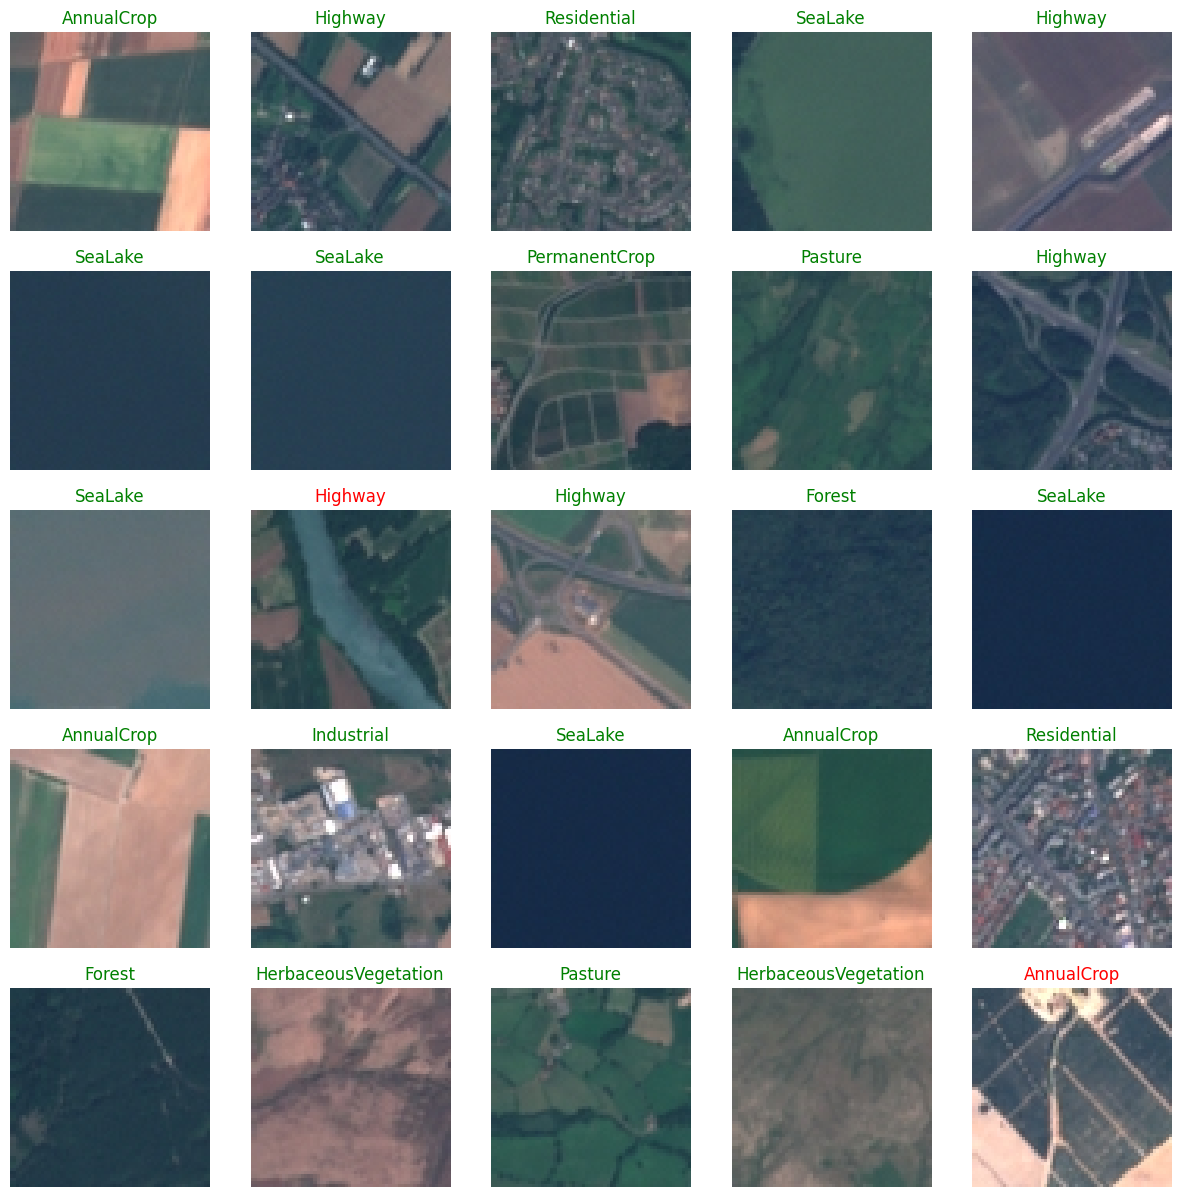

In [ ]:
plt.figure(figsize=(15, 15))
for i, datapoint in enumerate(tfds.as_numpy(test.take(25))):
  ax = plt.subplot(5, 5, i+1)
  plt.imshow(datapoint["image"])
  image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)
  image = preprocess_input(image)
  image = np.expand_dims(image, axis=0)

  if datapoint["label"] == np.argmax(model.predict(image)):
    plt.title(class_names[np.argmax(model.predict(image))], color="green")
  else:
    plt.title(class_names[np.argmax(model.predict(image))], color="red")

  plt.axis("off")

plt.show()